# Train a model
In the previous notebook, we processed some Raven annotation files so that we could use labeled audio as training data for a classifer. In this notebook, we will demonstrate how to train that classifier.

In [1]:
## import the CNN class from opensoundscape
from opensoundscape import CNN

# general purpose packages
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch 
import random 

# set random seeds to make the workflow reproducible
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[10,3] #default graphic size
%config InlineBackend.figure_format = 'retina'

#### Load the training and test sets

In [2]:
# read in the training and test sets produced from annotated audio, using the previous notebook
training_set = pd.read_csv("./resources/03/training_set.csv", index_col=[0,1,2])
test_set = pd.read_csv("./resources/03/test_set.csv", index_col=[0,1,2])

In [3]:
# Filter just to our species of interest
species_of_interest = ["NOCA", "EATO", "SCTA", "BAWW", "BCCH", "AMCR", "NOFL"]
training_set = training_set[species_of_interest]
test_set = test_set[species_of_interest]

In [4]:
# Split our training data into training and validation sets
train_df, valid_df = train_test_split(training_set, test_size=0.1, random_state=0)

### Resample data for even class representation

Here, we balance the number of samples of each class in the training set. 

In [5]:
## Roughly balance the training set ##
# this upsamples the less common classes and improves performance
# in classes that would otherwise be rare in the training set
positives_dfs = pd.concat([train_df[train_df[species] ==1].sample(800, replace=True, random_state=0) for species in train_df.columns])
negatives = train_df[train_df.sum(axis=1) == 0].sample(2000, replace=True)
balanced_train_df = pd.concat([positives_dfs, negatives])

Create the model object. We're using a resnet34 architecture CNN.

In [6]:
# create a CNN object designed to recognize 3-second samples
# we use the resnet34 architecture, 
model = CNN('resnet34',classes=train_df.columns,sample_duration=3.0, single_target=False)
model.device='mps'

#### initialize Weights and Biases logging session

Note: to use wandb logging, you will need to create an account on the [wandb website](https://wandb.ai/). The first time you use wandb, you'll be asked for an authentication key which can be found in your wandb profile. 

In [ ]:
import wandb
try:
    wandb_session = wanb.init(
        entity='kitzeslab',
        project='opensoundscape training demo',
        name='Notebook 03: Train CNN',
    )
except: #if wandb.init fails, don't use wandb logging
    wandb_session = None

## Training
train the model for 30 epochs

We use default training parameters, but many aspects of CNN training can be customized (see [this tutorial](http://opensoundscape.org/en/latest/tutorials/cnn_training_advanced.html) for examples)

Training can be a slow process, and the speed of training will depend on your computer. If you wish to skip this step, you can simply load the model that this cell would create by uncommenting the subsequent cell and running it instead

In [ ]:
%%capture --no-stdout --no-display

model.train(balanced_train_df, valid_df, epochs = 30, batch_size= 64, log_interval=100, num_workers = 32, wandb_session=wandb_session)

uncomment and run this cell to load the trained model object, instead of training the model using the cell above:

In [30]:
# # Load trained model
# from opensoundscape import load_model
# model = load_model('./resources/03/saved_cnn.model')

/Users/SML161/opensoundscape/opensoundscape/ml/cnn.py:1672: UserWarning: This model was saved with an earlier version of opensoundscape (0.8.0) and will not work properly in the current opensoundscape version (0.9.0). To use models across package versions use .save_torch_dict and .load_torch_dict
  warnings.warn(


## Use the model to predict on the test set
Again, this step can take a while depending on the speed of your computer. To skip this step and load the table of scores generated by the CNN, uncomment and run the subsequent cell instead of the one below:

In [15]:
predictions = model.predict(test_set)

KeyboardInterrupt: 

In [16]:
# # uncomment this cell to load the scores from a saved table instead of running the cell above
# predictions = pd.read_csv('./resources/03/cnn_predictions_test_set.csv',index_col=[0,1,2])

The table of predictions has a score for each class for each 3-second audio segment. 

In [17]:
predictions.head(2)

NOCA  \
file                                               start_time end_time             
/Users/SML161/demos-for-opso/ecy3329-sup-0001-d... 0.0        3.0      -3.724006   
                                                   3.0        6.0      -6.776401   

                                                                            EATO  \
file                                               start_time end_time             
/Users/SML161/demos-for-opso/ecy3329-sup-0001-d... 0.0        3.0      -3.340631   
                                                   3.0        6.0       1.162202   

                                                                            SCTA  \
file                                               start_time end_time             
/Users/SML161/demos-for-opso/ecy3329-sup-0001-d... 0.0        3.0      -6.241127   
                                                   3.0        6.0      -5.377924   

                                                                            BAWW  \
file                                               start_time end_time             
/Users/SML161/demos-for-opso/ecy3329-sup-0001-d... 0.0        3.0      -3.257714   
                                                   3.0        6.0      -5.708066   

                                                                            BCCH  \
file                                               start_time end_time             
/Users/SML161/demos-for-opso/ecy3329-sup-0001-d... 0.0        3.0      -0.565048   
                                                   3.0        6.0       0.167230   

                                                                            AMCR  \
file                                               start_time end_time             
/Users/SML161/demos-for-opso/ecy3329-sup-0001-d... 0.0        3.0      -0.596059   
                                                   3.0        6.0      -8.136910   

                                                                            NOFL  
file                                               start_time end_time            
/Users/SML161/demos-for-opso/ecy3329-sup-0001-d... 0.0        3.0      -1.927623  
                                                   3.0        6.0      -7.890665

## Visualize the model's attention to specific classes in a sample
The second clip in the test set contains an Eastern Towhee (EATO). Let's see what the model is paying attention to as it generates a score for that class. 

We'll use GradCAM (gradient class activation maps) to visualize the parts of a sample that are activated when the model predicts that the sample contains an Eastern Towhee vocalization.

In [17]:
# generate AudioSample objects with GradCAM maps
samples = model.generate_cams(samples=test_set.head(4),classes=['EATO'],guided_backprop=True) 

sample without a mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


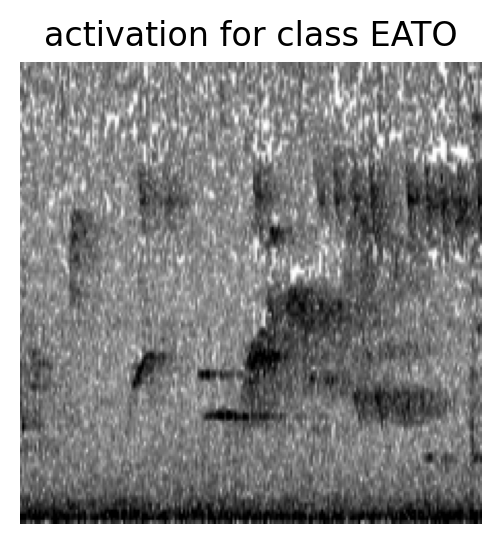

In [73]:
_=samples[3].cam.plot(target_class='EATO',alpha=0)

Visualize the GradCAM heatmap on Layer4 of the ResNet architecture

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


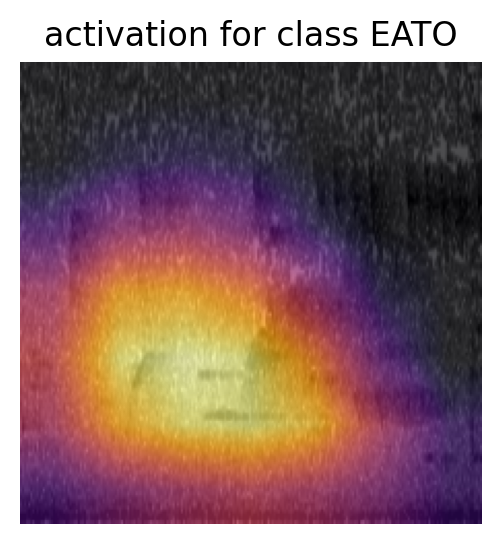

In [74]:
_=samples[3].cam.plot(target_class='EATO',alpha=0.7)

Show the activated pixels from the original sample with guided backpropagation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


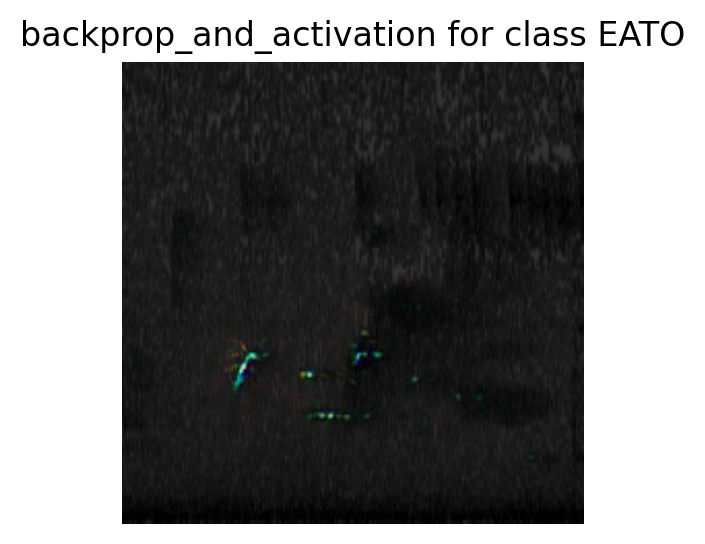

In [75]:
_=samples[3].cam.plot(target_class='EATO',alpha=0.8,mode='backprop_and_activation')

Great, this shows that the CNN is paying attention to the regions in the spectrogram that contain Eastern Towhee vocalizations, which led it to correctly predict the presence of Eastern Towhee in this sample. 

Interestingly, the CNN picks up on both the "scree" call and the early parts of the song. Because we haven't trained the CNN with separate classes for songs and calls, it does not differentiate between vocalization types, and considers all to be parat of the "EATO" class. 

## Plot the histograms for score distributions
We can validate the model's perfomance by plotting histograms of the scores outputted by the model on our test set. 

If a classifier performs well, it will give high scores to the positives (audio clips containing the species of interest) and lower scores to the negatives (audio clips that do not contain the species of interest). 

This classifier works well for some species, and has failed to learn others. Its performance would likely improve if we trained it with more data or adjusted training parameters. It could already be used to save a lot of listening effort if used for 'top-down listening' to confirm presence of a species at a site. Top-down listening is a process where audio clips are listened to by experts to verify presence at a site, starting with the highest scoring files and listening 'down' to lower scoring clips if necessary.

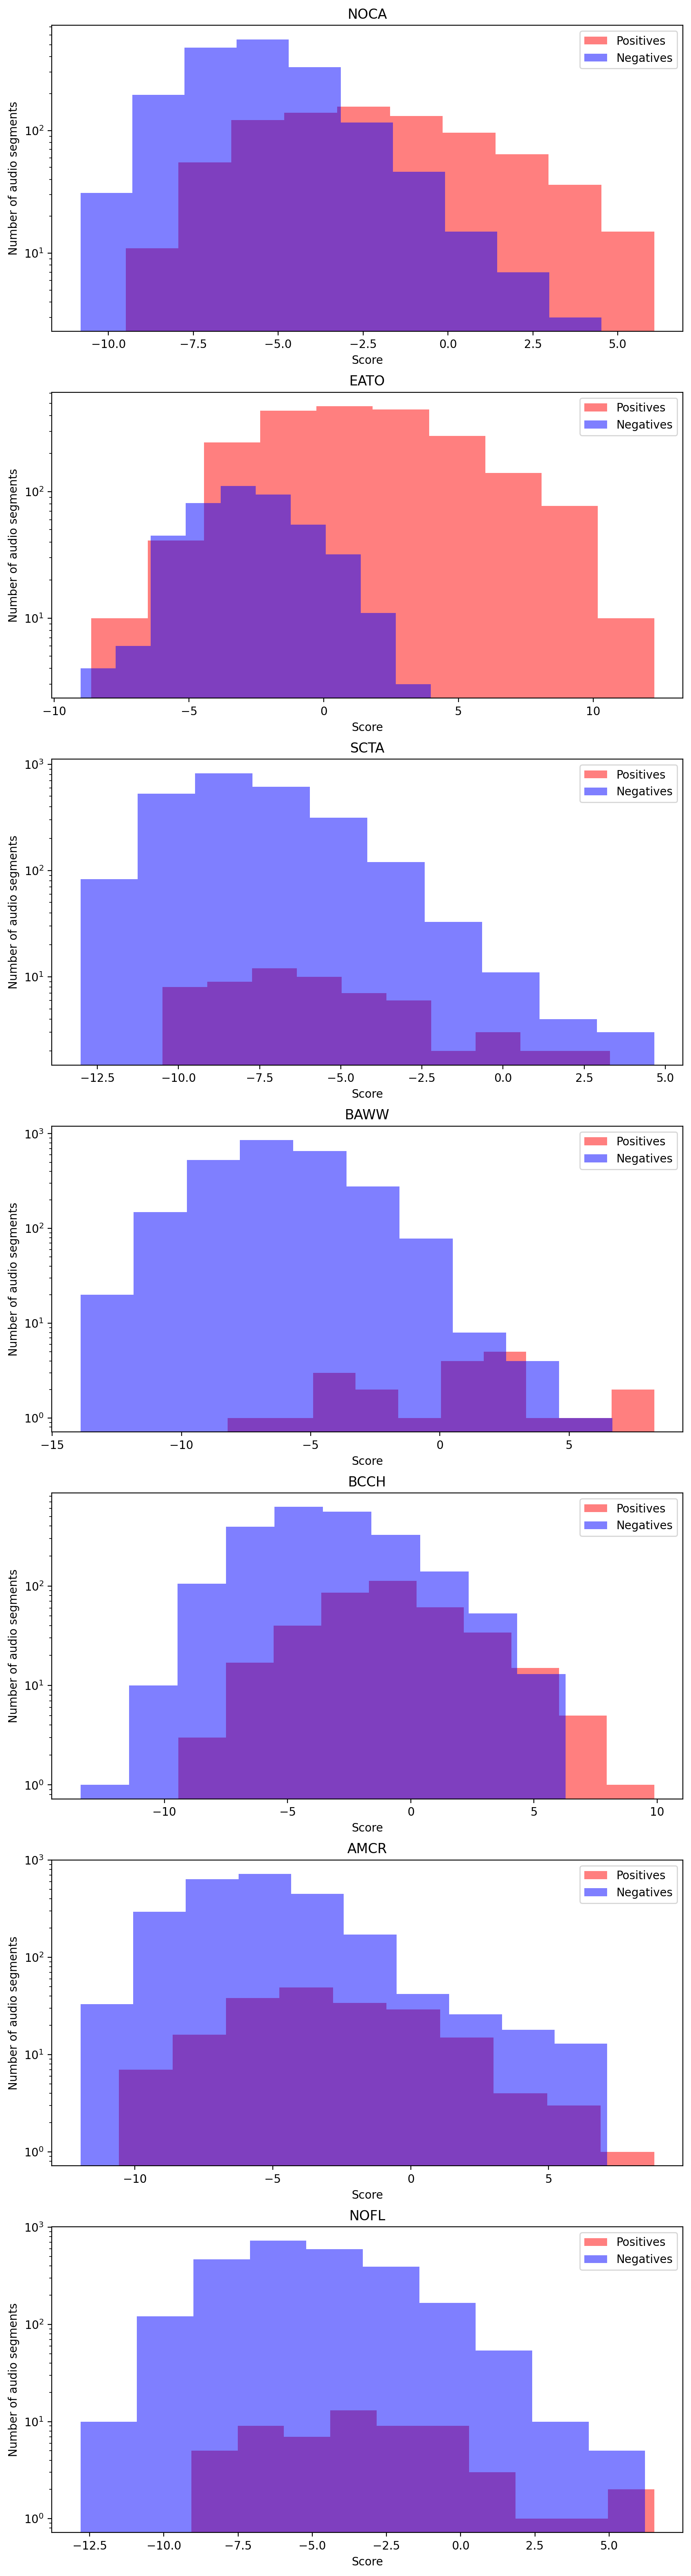

In [101]:
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(7,1, figsize = (10,40))
axs = np.ravel(axs)
for ax, species in enumerate(model.classes):
    positives = test_set[species] == 1
    negatives = test_set[species] == 0
    axs[ax].hist(predictions.loc[positives][species], alpha=0.5, color="red", label="Positives")
    axs[ax].hist(predictions.loc[negatives][species], alpha=0.5, color="blue", label="Negatives")
    axs[ax].set_yscale("log")
    axs[ax].title.set_text(species)
    axs[ax].set_ylabel("Number of audio segments")
    axs[ax].set_xlabel("Score")
    axs[ax].legend()

## Top Down listening 
This is a demonstration of how the model could be used for 'top-down listening', a method that greatly reduces the listening time needed to determine the presence of a species at a site. The idea of this approach is that we can validate the presence of a species very efficiently by reviewing the clip (or clips) with the highest CNN scores for that species. 

The loop selects the highest-scoring audio clip for each species across the entire test set. It asks the user to confirm whether that clip contains the species of interest. 

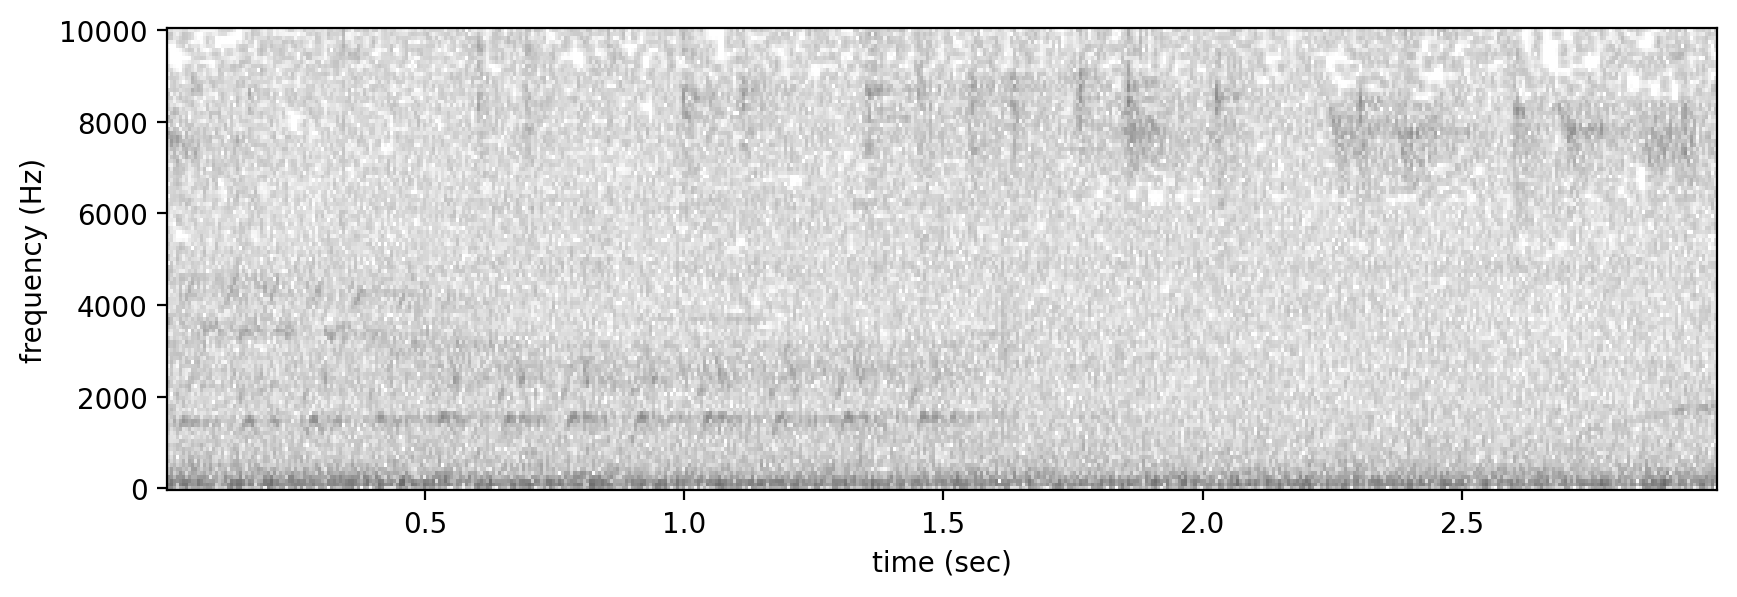

This is the highest scoring audio segment for NOFL. Does it contain NOFL? yes

User annotations of top-scoring clip per class:
{'NOCA': 'yes', 'EATO': 'yes', 'SCTA': 'no', 'BAWW': 'yes', 'BCCH': 'yes', 'AMCR': 'yes', 'NOFL': 'yes'}


In [15]:
from opensoundscape import Audio
from opensoundscape import Spectrogram
import IPython.display as ipd

user_annotations = {}
for species in model.classes:
    ipd.clear_output() #clear current displayed content
    
    #find the clip with the highest score for this species
    topscore = predictions[species].sort_values(ascending=False).index[0]
    audio = Audio.from_file(topscore[0], 
                            offset = topscore[1], 
                            duration = topscore[2]-topscore[1])
    
    #show interactive audio widget and spectrogram
    audio.show_widget(autoplay=True)
    Spectrogram.from_audio(audio).bandpass(0,10000).plot()
    
    #ask user for annotation
    user_input = input(f"This is the highest scoring audio segment for {species}. Does it contain {species}?")
    user_annotations.update({species:user_input})
    
    
print(f"\nUser annotations of top-scoring clip per class:")
print(user_annotations)